<a href="https://colab.research.google.com/github/chiru-stefan/AE-Emb---AI-Proj/blob/stefan/Autoencoder_4am.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install your required packages here
!pip install pandas numpy matplotlib sklearn fsspec gcsfs

In [2]:
# Location of credentials for accessing buckets
%env GOOGLE_APPLICATION_CREDENTIALS=/content/drive/My Drive/CS/AI/Credentials/ai-project-2020-f4dfbc25326c.json

env: GOOGLE_APPLICATION_CREDENTIALS=/content/drive/My Drive/CS/AI/Credentials/ai-project-2020-f4dfbc25326c.json


In [3]:
# Imports
from google.cloud import storage

import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, LSTM, Activation, Input, GRU,\
                                    Conv1D, RepeatVector, Conv1DTranspose
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define constants
bucket_name = "ai-project-2020-spotify"
client = storage.Client()
bucket = client.get_bucket(bucket_name)

In [6]:
# List bucket files
train_files = list(bucket.list_blobs(prefix='training_set/'))
for blob in [blob for blob in train_files if '20180715' in blob.name]:
  print(blob.name)

training_set/log_0_20180715_000000000000.csv.gz
training_set/log_1_20180715_000000000000.csv.gz
training_set/log_2_20180715_000000000000.csv.gz
training_set/log_3_20180715_000000000000.csv.gz
training_set/log_4_20180715_000000000000.csv.gz
training_set/log_5_20180715_000000000000.csv.gz
training_set/log_6_20180715_000000000000.csv.gz
training_set/log_7_20180715_000000000000.csv.gz


In [7]:
logs = pd.read_csv("/content/drive/My Drive/CS/AI/Data/training_set_mini.csv")
logs.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'],
      dtype='object')

In [8]:
unique_tracks = logs['track_id_clean'].nunique()
print(unique_tracks)

50704


In [9]:
def categorical_to_dummies(df, categorical_cols):
    """ Create dummies (one hot encoding) for each categorical variables """
    dummies = pd.get_dummies(df[categorical_cols], prefix=categorical_cols)
    return df.drop(columns=categorical_cols).join(dummies)

In [10]:
# remove date for convenience (could encode this as well)
logs.drop(columns=['date'], inplace=True)

# Create dummies (one hot encoding) for each categorical variable in logs
categorical_cols = ['context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
logs = categorical_to_dummies(logs, categorical_cols)

In [11]:
track_features = pd.read_csv('/content/drive/My Drive/CS/AI/Data/track_features_mini.csv').set_index('track_id')
track_features = categorical_to_dummies(track_features, ['mode'])

In [12]:
data = logs.join(track_features, on='track_id_clean', how='left').drop(columns=['track_id_clean'])

In [13]:
c_data = data[['session_id', 'session_position', 'duration', 'release_year',
       'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mechanism', # 'mode',
       'organism', 'speechiness', 'tempo', 'time_signature', 'valence',
       'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2',
       'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
       'acoustic_vector_6', 'acoustic_vector_7']]

Create training and test sets

In [14]:
def get_x_y():
  train_session_part = [_ for _ in range(15)]
  test_session_part = [_ for _ in range(15, 21)]

  x_train = c_data.loc[c_data.session_position.isin(train_session_part)].set_index('session_id')
  x_test = c_data.loc[c_data.session_position.isin(test_session_part)].set_index('session_id')
  y_train = data.loc[data.session_position.isin(train_session_part)].skip_2
  # y_train = np.reshape(y_train, (y_train.shape[0], x_train.shape[1]))
  y_test = data.loc[data.session_position.isin(test_session_part)].skip_2
  # y_test = np.reshape(y_test, (y_test.shape[0], x_test.shape[1]))
  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_x_y()

In [15]:
model = Sequential()
model.add(Input(shape=(None, 29)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))

# model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

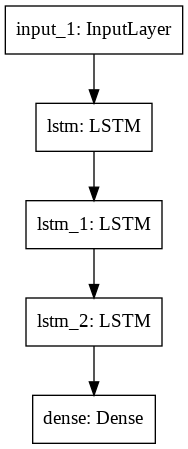

In [16]:
from keras.utils import plot_model
plot_model(model)

In [17]:
data_path = '/content/drive/My Drive/CS/AI/saved_models'
checkpointer = ModelCheckpoint(filepath=data_path + '/LSTM_model-{epoch:02d}.hdf5', verbose=1)

In [18]:
x_train = np.expand_dims(x_train, axis=0)
y_train = np.expand_dims(y_train, axis=0)

print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)

x_train.shape:  (1, 132629, 29)
y_train.shape:  (1, 132629)


In [19]:
model.fit(x_train, y_train, batch_size=1000, epochs=3, callbacks=[checkpointer])

Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.4871
Epoch 00001: saving model to /content/drive/My Drive/CS/AI/saved_models/LSTM_model-01.hdf5
1/1 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.4871
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.4871
Epoch 00002: saving model to /content/drive/My Drive/CS/AI/saved_models/LSTM_model-02.hdf5
1/1 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.4871
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.4871
Epoch 00003: saving model to /content/drive/My Drive/CS/AI/saved_models/LSTM_model-03.hdf5
1/1 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.4871


In [140]:
def AE(input_dim,output_dim, INTERMEDIARY_ZIZE=16):
  model = Sequential()
  model.add(Input(shape=(input_dim,1)))
  #encoder
  model.add(LSTM(INTERMEDIARY_ZIZE))

  #decoder
  model.add(RepeatVector(1))
  model.add(LSTM(input_dim, return_sequences=True))
  model.add(Dense(output_dim, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_crossentropy'])
  print(model.summary())
  return model

## Track embedding



In [ ]:
tracks = track_features.copy()
tracks_ext = np.expand_dims(tracks, axis=-1)
tracks = np.expand_dims(tracks, axis=1)
print('tracks_ext.shape: ', tracks_ext.shape)
print('tracks.shape: ', tracks.shape)

checkpointer_ae = checkpointer_anomaly = ModelCheckpoint(filepath=data_path + '/AE_model-{epoch:02d}.hdf5', verbose=1)
model = AE(len(track_features.columns),len(track_features.columns))
model.fit(tracks_ext, tracks, epochs=30, callbacks=[checkpointer_ae], batch_size=1000)

In [143]:
result = model.predict(np.expand_dims(tracks_ext[0,:], axis=1))

## Session encoding


## Playback encoding

### **Anomaly detection**

In [20]:
no_features = 29

In [187]:
model_anomaly = Sequential(
    [
        Input(shape=(x_train.shape[0], x_train.shape[2])),
        Conv1D(
            filters=30, kernel_size=14, padding="same", strides=1, activation="relu"
        ),
        Dropout(rate=0.5),
        Conv1D(
            filters=15, kernel_size=14, padding="same", strides=1, activation="relu"
        ),
        Conv1DTranspose(
            filters=15, kernel_size=14, padding="same", strides=1, activation="relu"
        ),
        Dropout(rate=0.5),
        Conv1DTranspose(
            filters=30, kernel_size=14, padding="same", strides=1, activation="relu"
        ),
        Conv1DTranspose(filters=1, kernel_size=15, padding="same"),
    ]
)
model_anomaly.compile( optimizer='adam', metrics=['accuracy'], loss="mse")
model_anomaly.summary()


Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 1, 30)             12210     
_________________________________________________________________
dropout_40 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 1, 15)             6315      
_________________________________________________________________
conv1d_transpose_60 (Conv1DT (None, 1, 15)             3165      
_________________________________________________________________
dropout_41 (Dropout)         (None, 1, 15)             0         
_________________________________________________________________
conv1d_transpose_61 (Conv1DT (None, 1, 30)             6330      
_________________________________________________________________
conv1d_transpose_62 (Conv1DT (None, 1, 1)            

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         80896     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 142,753
Trainable params: 142,753
Non-trainable params: 0
_________________________________________________________________


Trying to use stack_session on another format of Dataframe

In [23]:
train_session_part = [_ for _ in range(15)]
test_session_part = [_ for _ in range(15, 21)]

x_train_anomaly = c_data.loc[c_data.session_position.isin(train_session_part)].set_index('session_id')
x_test_anomaly = c_data.loc[c_data.session_position.isin(test_session_part)].set_index('session_id')
y_train_anomaly = data.loc[data.session_position.isin(train_session_part)].skip_2
# y_train = np.reshape(y_train, (y_train.shape[0], x_train.shape[1]))
y_test_anomaly = data.loc[data.session_position.isin(test_session_part)].skip_2

In [24]:
def stack_sessions(df, remove_cols = True):
    columns = list(df.columns)
    if remove_cols == True:
      columns.remove('session_id')
      columns.remove('session_position')
      sessions = df.pivot(index='session_id', columns='session_position', values=columns)
    else:
      if 'session_position' in df.columns:
        sessions = df.pivot(columns='session_position', values=columns)
      else:
        sessions = df.pivot(columns='skip_2', values=columns)
    return sessions

In [25]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

imp_x_train_anomaly = imp.fit_transform( stack_sessions(x_train_anomaly, False) )
imp_y_train_anomaly = imp.fit_transform( stack_sessions(y_train_anomaly.to_frame(), False) )
imp_x_test_anomaly = imp.fit_transform( stack_sessions(x_test_anomaly, False) )
imp_y_test_anomaly = imp.fit_transform( stack_sessions(y_test_anomaly.to_frame(), False) )

In [26]:
# Convert back to DataFrame
df_imp_x_train_anomaly = pd.DataFrame(columns=list(stack_sessions(x_train_anomaly, False).columns), data=imp_x_train_anomaly)
df_imp_y_train_anomaly = pd.DataFrame(columns=list(stack_sessions(y_train_anomaly.to_frame(), False).columns), data=imp_y_train_anomaly)
df_imp_x_test_anomaly = pd.DataFrame(columns=list(stack_sessions(x_test_anomaly, False).columns), data=imp_x_test_anomaly)
df_imp_y_test_anomaly = pd.DataFrame(columns=list(stack_sessions(y_test_anomaly.to_frame(), False).columns), data=imp_y_test_anomaly)


In [189]:
x_train, y_train, x_test, y_test = get_x_y()
checkpointer_anomaly = ModelCheckpoint(filepath=data_path + '/Conv1D_model-{epoch:02d}.hdf5', verbose=1)
x_train = np.expand_dims(x_train, axis=0)
y_train = np.expand_dims(y_train, axis=0)

print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)

#(batch_size, sequence_length, num_features) 
model_anomaly.fit(x_train, y_train, batch_size=5, epochs=50, callbacks=[checkpointer_anomaly])

x_train.shape:  (1, 132629, 29)
y_train.shape:  (1, 132629)
Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 2386.2214 - accuracy: 0.5046
Epoch 00001: saving model to /content/drive/My Drive/CS/AI/saved_models/Conv1D_model-01.hdf5
1/1 [==============================] - 0s 6ms/step - loss: 2386.2214 - accuracy: 0.5046
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 1639.0496 - accuracy: 0.5060
Epoch 00002: saving model to /content/drive/My Drive/CS/AI/saved_models/Conv1D_model-02.hdf5
1/1 [==============================] - 0s 6ms/step - loss: 1639.0496 - accuracy: 0.5060
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 1133.6595 - accuracy: 0.5071
Epoch 00003: saving model to /content/drive/My Drive/CS/AI/saved_models/Conv1D_model-03.hdf5
1/1 [==============================] - 0s 6ms/step - loss: 1133.6595 - accuracy: 0.5071
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 789.4409 - accuracy: 0.5042
Epoch 00004: savin

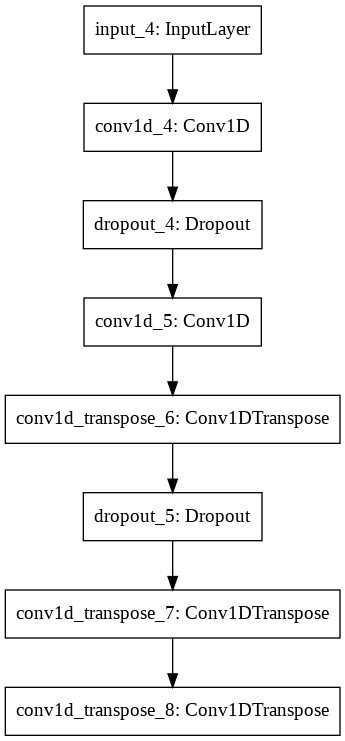

In [38]:
plot_model(model_anomaly)

### ***From here on is Jens code***
########################################

In [28]:
# Stack all Sessions
model_input = stack_sessions(data)
model_input_original = model_input.copy(deep=True)
# Drop all features except track_id, skip_2, session_ids
model_input.head()

session_length          ... mode_minor          
session_position                                   1   2   3   ...         18   19   20
session_id                                                     ...                     
0_00006f66-33e5-4de7-a324-2d18e439fc1e             20  20  20  ...          1    1    0
0_0000a72b-09ac-412f-b452-9b9e79bded8f             20  20  20  ...          0    1    0
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a             20  20  20  ...          0    1    1
0_00016a3d-9076-4f67-918f-f29e3ce160dc             20  20  20  ...          0    0    0
0_00018b58-deb8-4f98-ac5e-d7e01b346130             11  11  11  ...        NaN  NaN  NaN

[5 rows x 1320 columns]

In [29]:
# Add noise to the skip_2 values
for i, row in model_input.iterrows():
  for index in range(1, 20):
    value = row[('skip_2', index)]
    if not math.isnan(value):
      noise = np.random.randint(2, size=1)
      noisy_value = np.bitwise_and(int(value), noise[0])
      model_input.at[i,('skip_2', index)] = noisy_value

In [30]:
model_input.head()

session_length          ... mode_minor          
session_position                                   1   2   3   ...         18   19   20
session_id                                                     ...                     
0_00006f66-33e5-4de7-a324-2d18e439fc1e             20  20  20  ...          1    1    0
0_0000a72b-09ac-412f-b452-9b9e79bded8f             20  20  20  ...          0    1    0
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a             20  20  20  ...          0    1    1
0_00016a3d-9076-4f67-918f-f29e3ce160dc             20  20  20  ...          0    0    0
0_00018b58-deb8-4f98-ac5e-d7e01b346130             11  11  11  ...        NaN  NaN  NaN

[5 rows x 1320 columns]

In [31]:
model_input.reset_index(inplace=True)
model_input.drop(columns=['session_id'])
model_input_original.reset_index(inplace=True)
model_input_original.drop(columns=['session_id'])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


session_length                  ... mode_minor                    
session_position             1   2   3   4   5   ...         16   17   18   19   20
0                            20  20  20  20  20  ...          1    1    1    1    0
1                            20  20  20  20  20  ...          0    1    0    1    0
2                            20  20  20  20  20  ...          1    1    0    1    1
3                            20  20  20  20  20  ...          0    0    0    0    0
4                            11  11  11  11  11  ...        NaN  NaN  NaN  NaN  NaN
...                         ...  ..  ..  ..  ..  ...        ...  ...  ...  ...  ...
9995                         20  20  20  20  20  ...          1    0    0    1    0
9996                         20  20  20  20  20  ...          0    0    1    0    0
9997                         20  20  20  20  20  ...          0    1    0    1    0
9998                         12  12  12  12  12  ...        NaN  NaN  NaN  NaN  NaN
9999                         20  20  20  20  20  ...          1    1    0    1    0

[10000 rows x 1320 columns]

In [32]:
%%time
from sklearn.impute import SimpleImputer

# Fill in NaN values with mean of column. This choice *should* depend on your decision of classifier and feature encoding. Not every approach has the same assumptions about the data.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_data_imp = imp.fit_transform(model_input.drop(columns=['session_id']))
val_data_imp = imp.transform(model_input_original.drop(columns=['session_id']))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


CPU times: user 1.79 s, sys: 49 ms, total: 1.84 s
Wall time: 1.83 s
